## Imports 

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from pprint import pprint
import random
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import math
from tensorflow.keras.models import Model

img_size = 124  

## Directories having data
"metadata_directory" - Contains data about the images including file name, bounding box coordinates, class name (Masked or Non Masked) to name a few
"image_directory" - Contains the actual images

In [2]:
metadata_directory = "C:/archive/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "C:/archive/Medical mask/Medical mask/Medical Mask/images"


In [3]:
def bounding_box(i, j):
    x,y,w,h = j["BoundingBox"]
    img = cv2.imread(os.path.join(image_directory,i),1)
    img = img[y:h,x:w]
    img = cv2.resize(img,(img_size,img_size))
    return img

## Dispaying JSON structure of metadata 

In [4]:
mask_class = []
data = []

def getJSON(filepath):
    with open(filepath) as f:
        return json.loads(f.read())

filenames = os.listdir(metadata_directory)
jsonfiles = [os.path.join(metadata_directory, filename) for filename in filenames]
jsondata = []
for jsonfile in jsonfiles:
    attr = getJSON(jsonfile)
    for i in attr["Annotations"]:
        if i["classname"] == 'face_no_mask':
            mask_class.append("No Mask")
            data.append([bounding_box(attr["FileName"], i), 1])
        elif i["classname"] == 'face_with_mask':
            mask_class.append("Mask")
            data.append([bounding_box(attr["FileName"], i), 0])
    jsondata.append(attr)
pprint(jsondata[0])
random.shuffle(data)

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [451, 186, 895, 697],
                  'Confidence': 1,
                  'ID': 924868908868875136,
                  'classname': 'face_no_mask',
                  'isProtected': False}],
 'FileName': '1801.jpg',
 'NumOfAnno': 1}


## Metadata in csv format

In [5]:
df = pd.read_csv("C:/archive/train.csv")
df.head

<bound method NDFrame.head of            name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
2      2756.png   75  252  264  390   mask_colorful
3      2756.png  521  136  711  277   mask_colorful
4      6098.jpg  360   85  728  653    face_no_mask
...         ...  ...  ...  ...  ...             ...
15407  1894.jpg  437  121  907  644  face_with_mask
15408  1894.jpg  557  363  876  636   mask_surgical
15409  1894.jpg  411    3  940  325             hat
15410  3216.png  126   69  409  463  face_with_mask
15411  3216.png  136  289  393  461   mask_colorful

[15412 rows x 6 columns]>

## Plot of the amount of data available into two different classes - Masked and Non Masked

Counter({'Mask': 4180, 'No Mask': 1569})


<Axes: xlabel='count'>

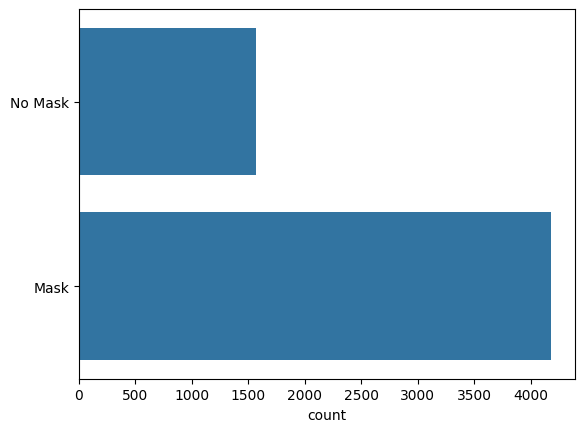

In [6]:
pprint(Counter(mask_class))
sns.countplot(mask_class)

## Model Architecture

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 460800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 460800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │      23,040,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,133,349 (88.25 MB)

 Trainable params: 23,133,349 (88.25 MB)

 Non-trainable params: 0 (0.00 B)

## Model configuration to start training
Defined parameters - loss function, optimizer and the metrics to be evaluated during training and testing

In [8]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001) ,metrics=['accuracy'])

In [9]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)
    
print("Shape of X -> ", X[0].shape)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

print("Unique elements in Y -> ", np.unique(Y))
print("Shape of Y -> ", Y.shape)

Shape of X ->  (124, 124, 3)
Unique elements in Y ->  [0 1]
Shape of Y ->  (5749,)


## Splitting available data into training and testing dataset. Size of Train data - 80% and Size of Testing data - 10% and Size of Validation data - 10%

In [10]:
xtrain,xtest,ytrain,ytest=train_test_split(X, Y,train_size=0.8,random_state=0)
xtrain,xval,ytrain,yval=train_test_split(xtrain, ytrain,train_size=0.875,random_state=0)

## ImageDataGenerator is used to augment your images. It can standardize, rotate, shift, flip, change brightness, etc of your image.

In [11]:
print(f"Training Size: {len(xtrain)}")
print(f"Testing Size: {len(xtest)}")
print(f"Validation Size: {len(xval)}")

Training Size: 4024
Testing Size: 1150
Validation Size: 575


In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [13]:
early_stop = EarlyStopping(monitor='accuracy',patience=4,mode='max')

## Training model with early stopping

In [14]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=16),
                    epochs=50,
                    callbacks=[early_stop],
                    verbose=1,
                    validation_data=(xval, yval))

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.8164 - loss: 0.4018 - val_accuracy: 0.8991 - val_loss: 0.2218
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.8919 - loss: 0.2637 - val_accuracy: 0.8730 - val_loss: 0.3166
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9055 - loss: 0.2488 - val_accuracy: 0.9217 - val_loss: 0.1992
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.8952 - loss: 0.2545 - val_accuracy: 0.9235 - val_loss: 0.1932
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.9066 - loss: 0.2299 - val_accuracy: 0.9235 - val_loss: 0.1825
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.9105 - loss: 0.2319 - val_accuracy: 0.9183 - val_loss: 0.2010
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.9228 - loss: 0.1991 - val_accuracy: 0.9304 - val_loss: 0.1722
Epoch 8/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.9100 - loss: 0.2178 - val_accu

## Results on test dataset 

In [15]:
test_loss,test_accuracy = model.evaluate(xtest, ytest)
print('Test Loss for Model: ',test_loss)
print('Test Accuracy for Model: ',test_accuracy)

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.9556 - loss: 0.1273
Test Loss for Model:  0.13049274682998657
Test Accuracy for Model:  0.9495652318000793


## Model Accuracy and Model Loss

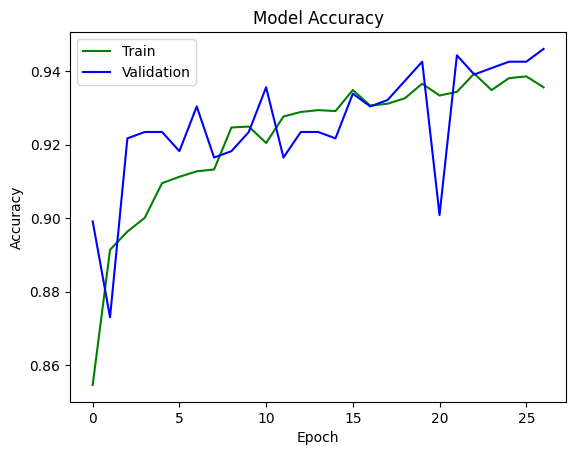

In [16]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

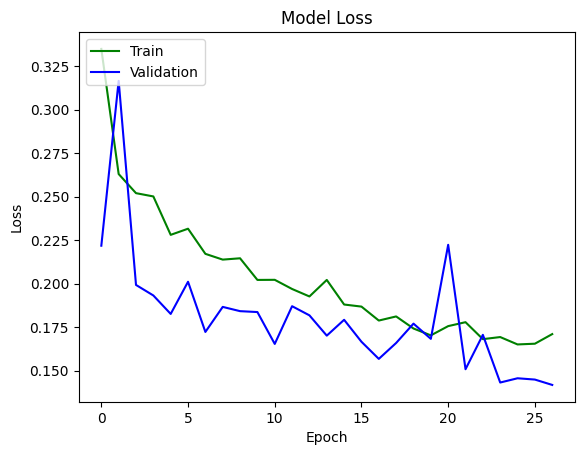

In [17]:

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Saving model 

In [18]:
model.save("mask_prediction.h5")

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# Predict on test set
y_pred_probs = model.predict(xtest)  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert probabilities to binary labels

# Calculate evaluation metrics
f1 = f1_score(ytest, y_pred)
precision = precision_score(ytest, y_pred)
recall = recall_score(ytest, y_pred)
accuracy = accuracy_score(ytest, y_pred)
conf_matrix = confusion_matrix(ytest, y_pred)

# Print the metrics
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step 
F1 Score: 0.8989547038327527
Precision: 0.8927335640138409
Recall: 0.9052631578947369
Accuracy: 0.9495652173913044
Confusion Matrix:
 [[834  31]
 [ 27 258]]


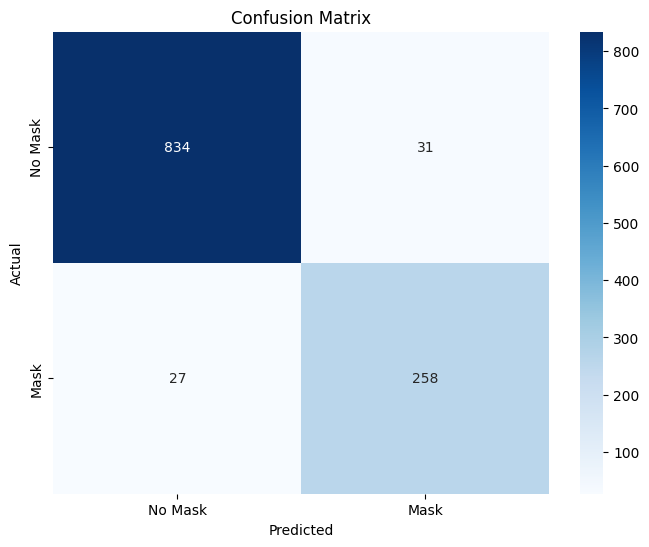

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Loading SSD model for Face detection for testing

In [10]:
cvNet = cv2.dnn.readNetFromCaffe('C:/SSD model/architecture.txt','C:/SSD model/weights.caffemodel')

In [11]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [12]:
def processImage(image):
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.15, (36,255,12), 3)
        except:pass
    return image

## predicting faces in dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


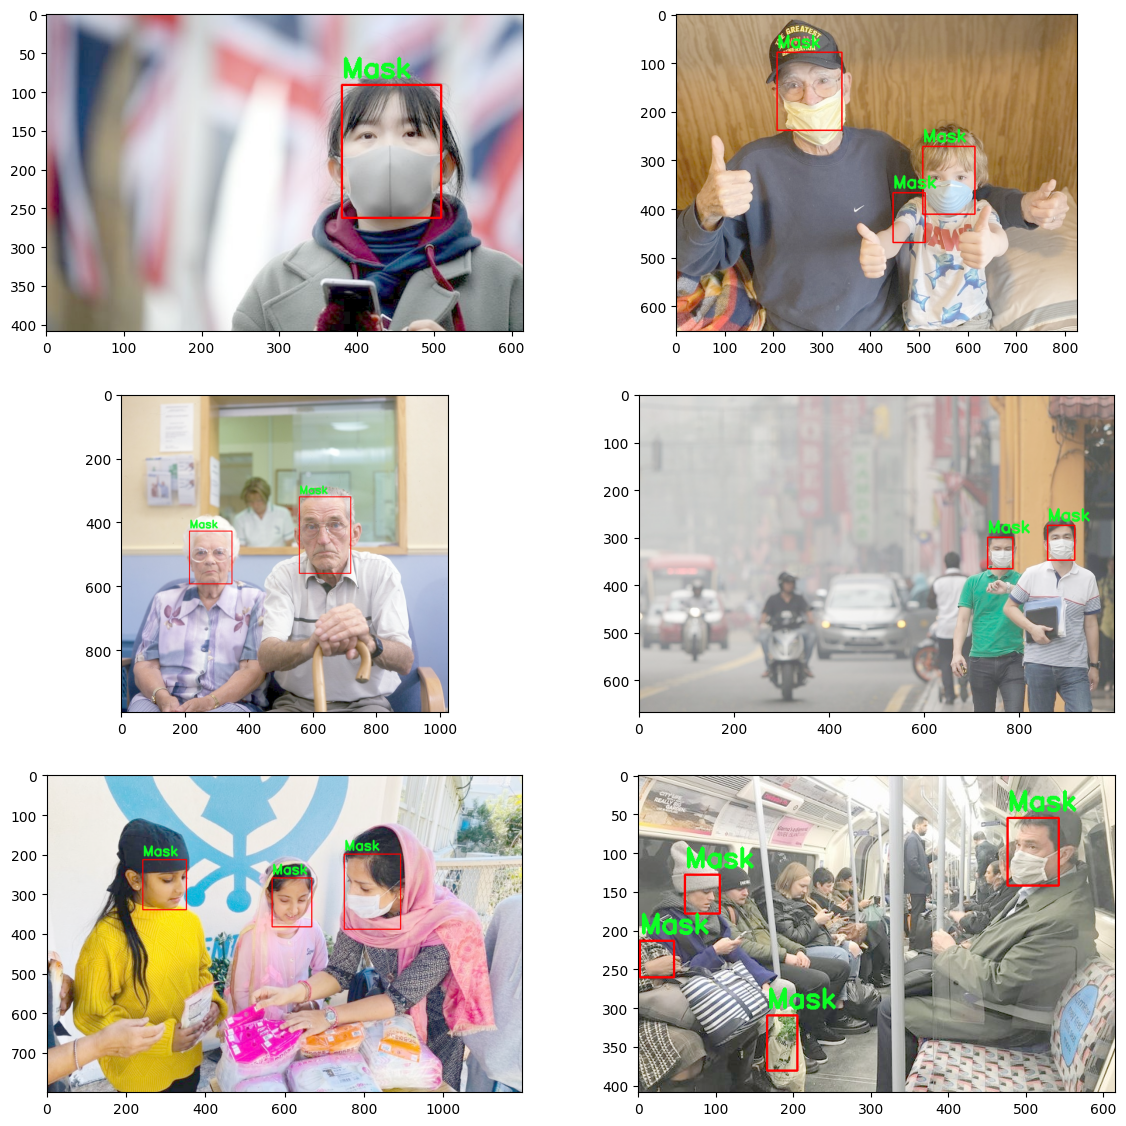

In [15]:
test_images = ['0063.jpg','0321.jpg', '0380.jpg','0122.jpeg','0076.jpg','0065.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image = processImage(image)
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Features at every convolutional layer


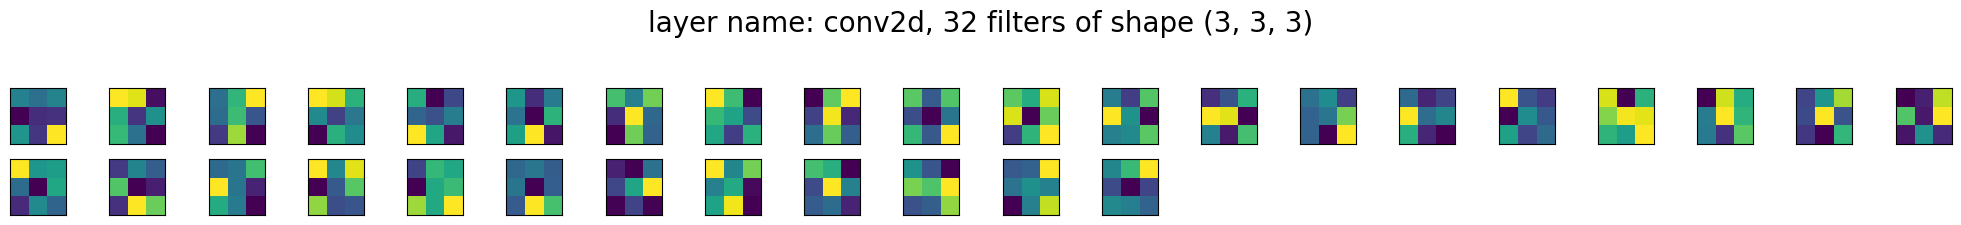

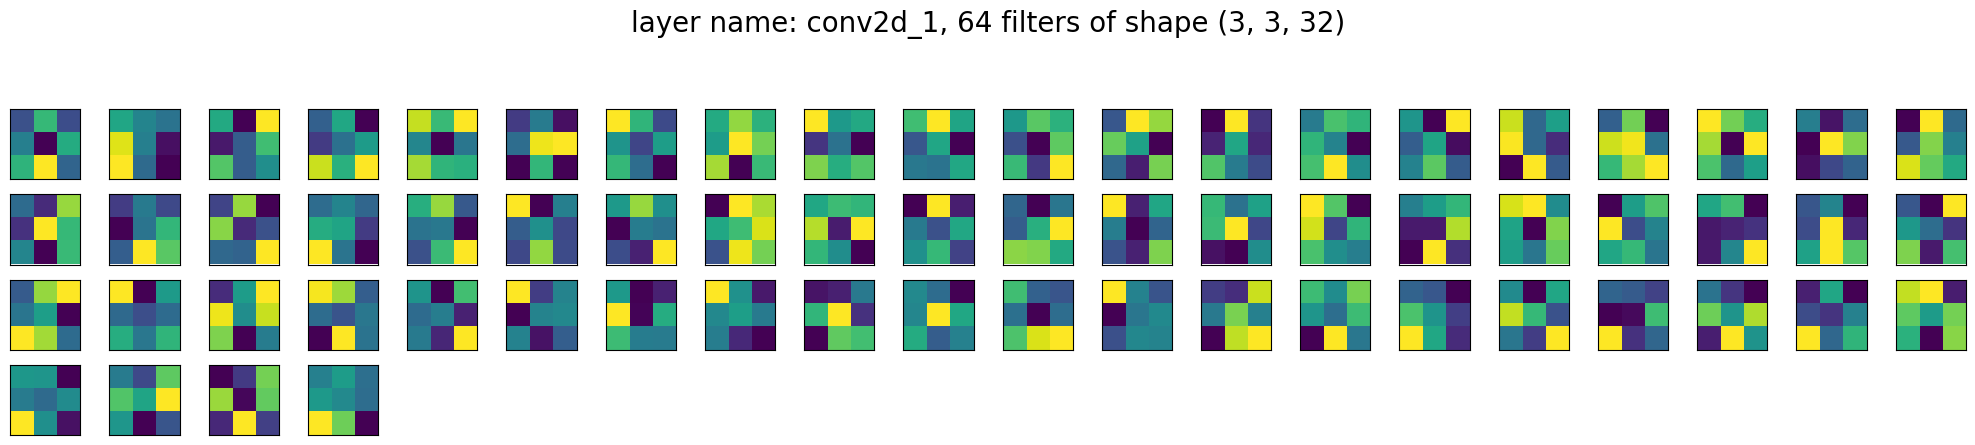

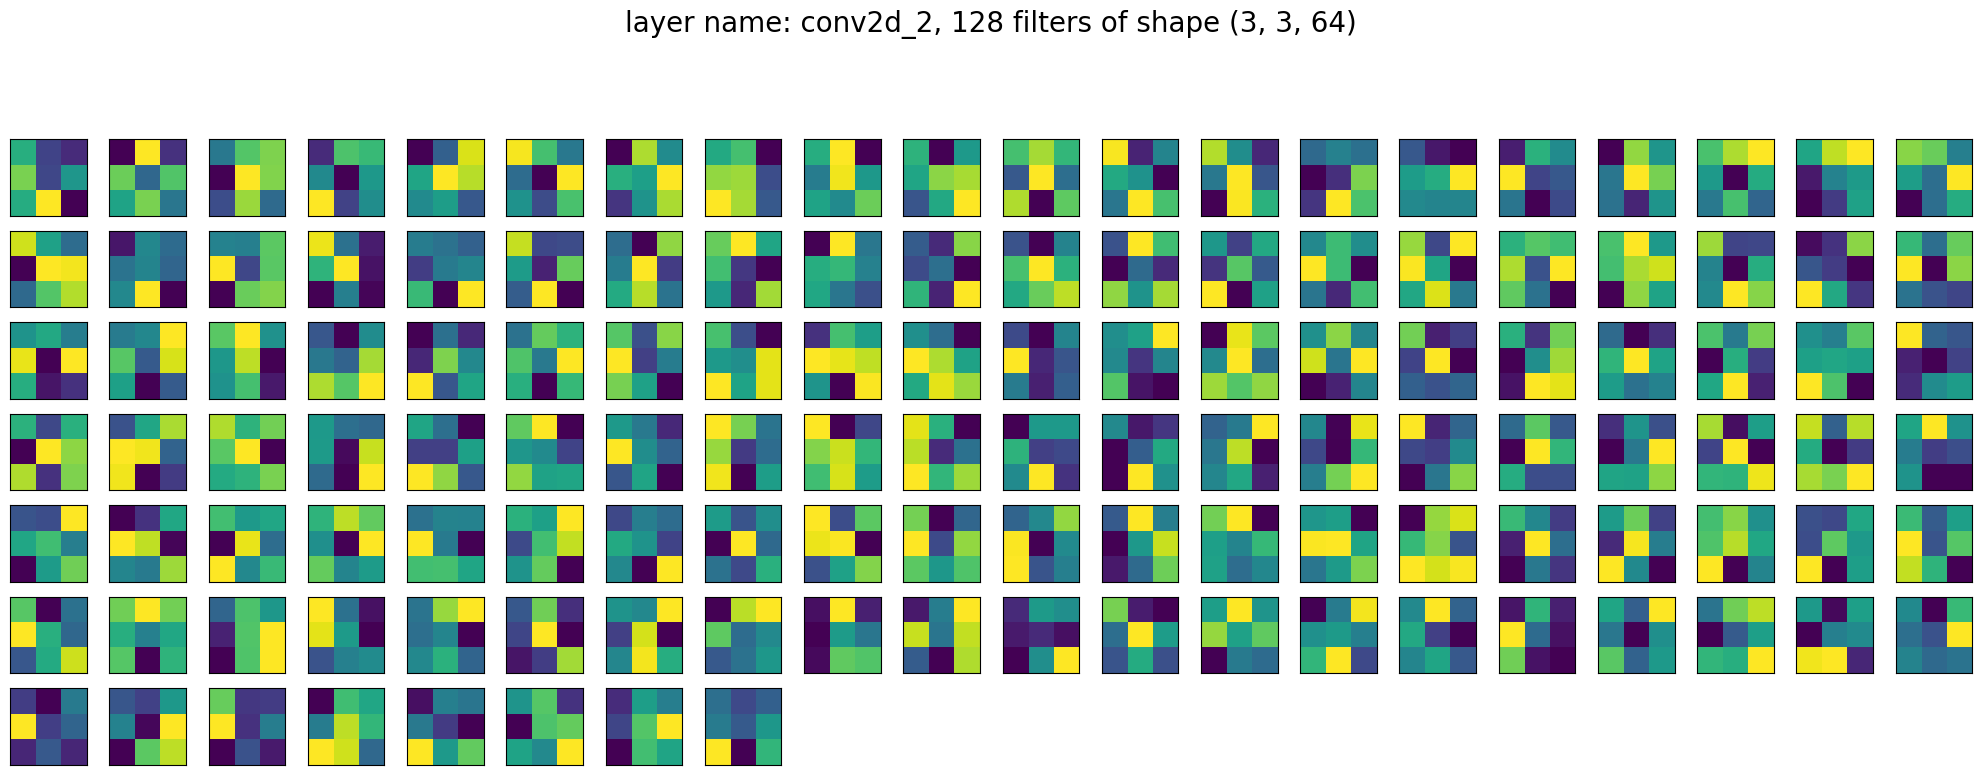

In [16]:

layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

INTERESTED_CONV_LAYERS = ["conv2d", "conv2d_1", "conv2d_2"]

idx = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:        
        layer_output = layer[1].output
        filters, bias = layer[1].get_weights()     
        filters = (filters - filters.min()) / (filters.max() - filters.min())
    
        cols = 20
        rows = math.ceil(filters.shape[-1] / cols)
        fig = plt.figure(idx, (20, rows))

        idx += 1
        for i,f in enumerate(np.rollaxis(filters, 3)):
            ax = plt.subplot(rows, cols, i+1)
            f = np.mean(f, axis=2)
            ax.imshow(f, cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            plt.suptitle(f"layer name: {layer[0]}, {filters.shape[3]} filters of shape {filters.shape[:-1]}", fontsize=20, y=1.1)
            plt.tight_layout()



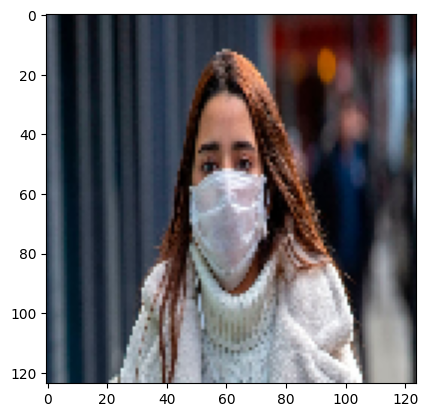

(124, 124, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 124, 124, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


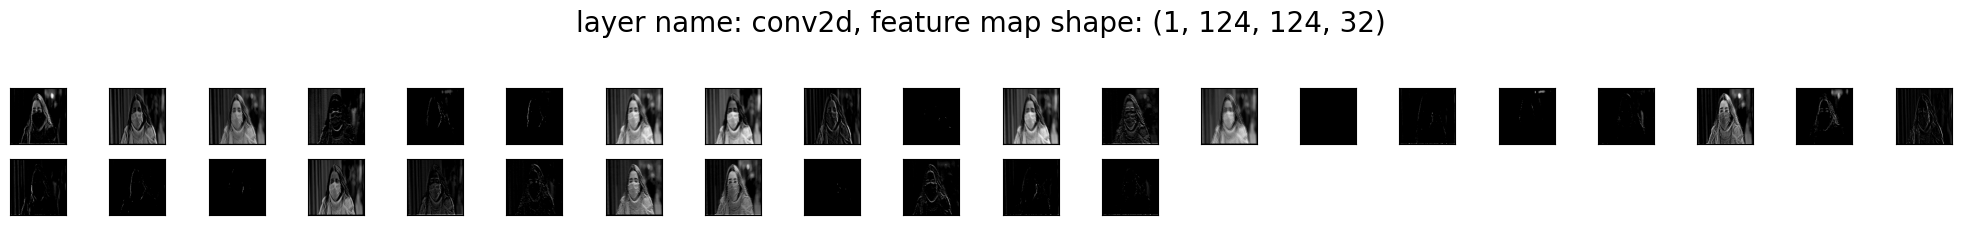

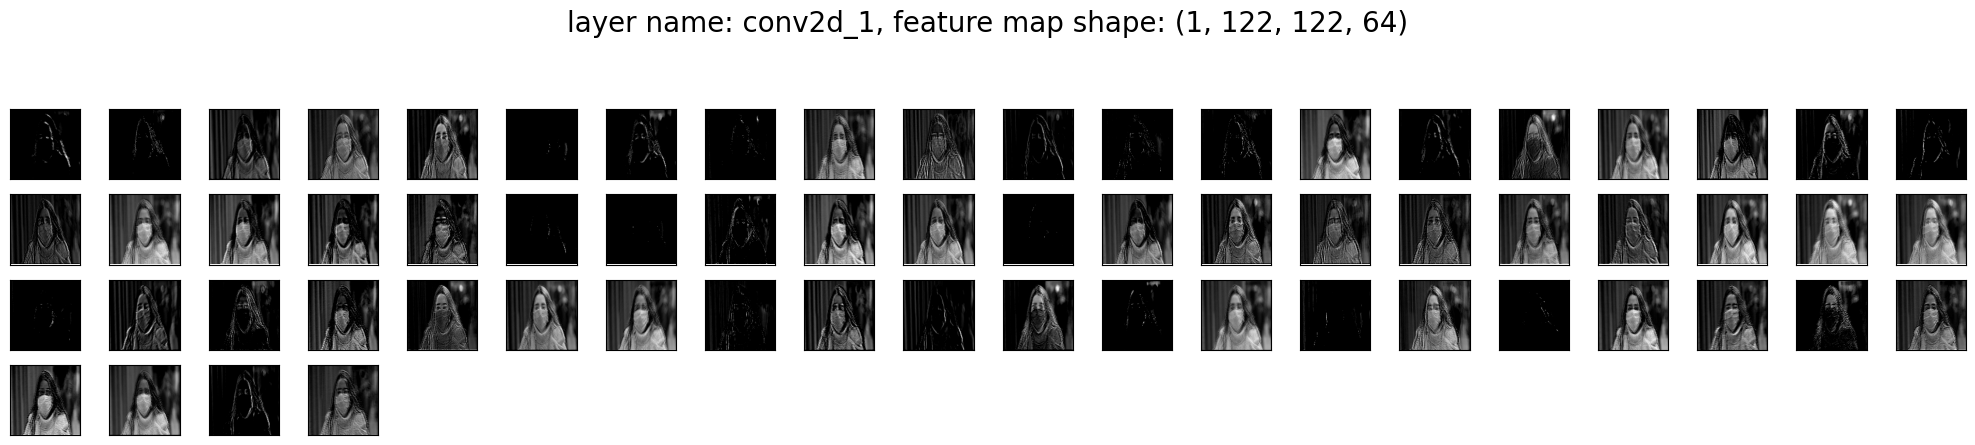

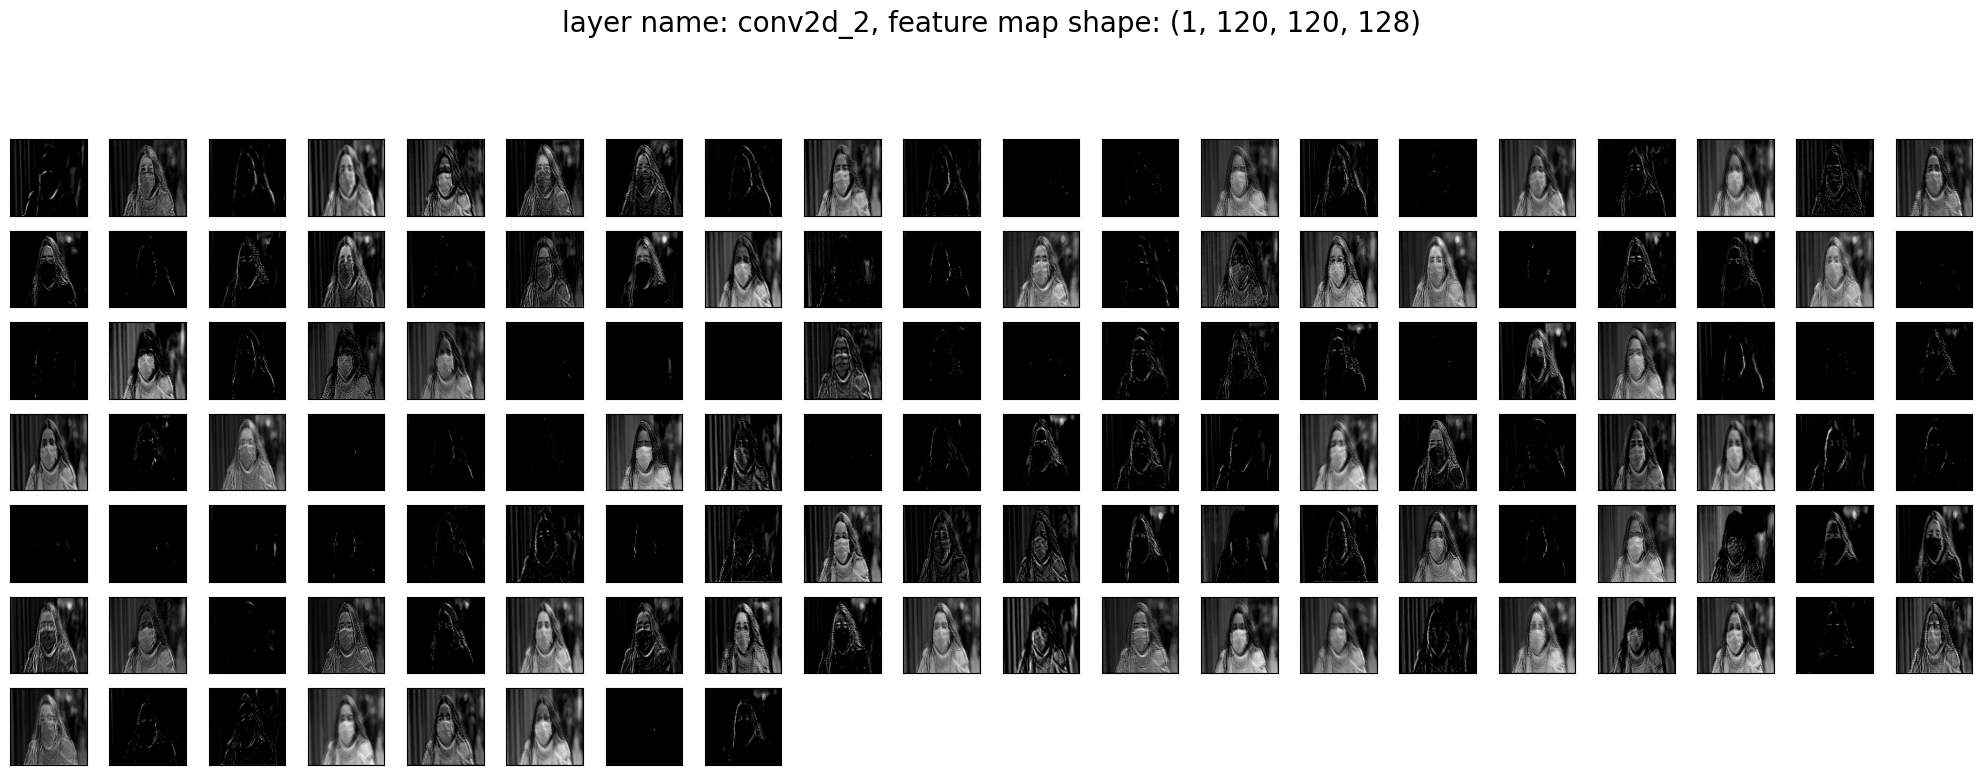

In [21]:

layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]

sample_img = cv2.imread(os.path.join(image_directory,'0055.jpg'))

sample_img = cv2.resize(sample_img,(img_size,img_size))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
print(sample_img.shape)

sample_img = np.expand_dims(sample_img, axis=0)

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(sample_img)

        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        fig = plt.figure(i, (20, rows))        
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = plt.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            plt.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            plt.tight_layout()